# NOTEBOOK COMPRESSED SENSING

Dans ce notebook nous avons décrit la mise en place de l'algorithme présenté dans l'article. Tout d'abord, on rapellera brievement l'algorithme général, puis les trois grandes etapes de l'algorithme seront implementées. Pour chaque fonction un test sera effectué pour s'assurer du fonctionemment correct de l'implementation.

Le $BPDQ_p$ se traduit par un problème de minimisation convexe avec des fonctions non differentiables. Pour le résoudre on va mettre en place l'agorithme de Douglas-Ratchford, que l'on nommera "Douglas".

Pour le mettre en place il faut créer une fonction de seuil mou (appelé "softthresh" ici) et une fonction qui calcule la projection orthogonale d'un vecteur sur le tube $T^p(\epsilon)$ (appelé "ProjectionTube" ici). Il n'est cependant pas aisé de calculer le projeté sur $T^p(\epsilon)$, il faut donc procéder en deux étapes:

La première consiste à créer la fonction qui permet de projeter un vecteur sur la boule unité pour la norme $p$. La deuxième étape consiste à utiliser cette fonction pour créer la projection sur $T^p(\epsilon)$.

# Imports, génération de données et autres fonctions utiles

Dans cette partie on importe les packages nécessaires, on crée nos données avec les fonctions vues en TD et on crée la fonction $norme_p$ (ynorm) qui va etre utile dans la suite

In [706]:
#Imports
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import *
import random as rd
import math as math
%matplotlib inline
import time
import copy

In [27]:
def ynorm(y,p):
    return sum(abs(y**p))**(1/p)

In [123]:
ynorm(np.array([3,4]),2.)

5.0

In [4]:
#Creation du signal
def signal(N, s):    
    l=np.zeros(N)
    k=range(N)
    rd.shuffle(k)
    for i in k[0:s]:
        l[i]=norm.rvs(size=1).tolist()[0]
    return l

In [937]:
signal(100,5)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -1.20779401,
        0.        ,  0.        ,  0.43008123,  0.        ,  0.        ,
       -0.81742327,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.78071739,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.24203196,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [5]:
# Creation de la matrice de gaussiennes
def measurement_matrix(m, N, rand_type = "gauss", power = 2):
    if rand_type=="gauss":
        R=np.random.randn(m,N)

    if rand_type=="student":
        R=t.rvs(power,size=m*N)
        R=R.reshape( (m,N) )
    return R

In [935]:
measurement_matrix(3, 10, rand_type = "gauss", power = 2)

array([[-0.07724139,  0.01617193, -0.41939311, -0.12465419, -1.03771067,
         1.46232407,  0.98909928,  0.42381823, -0.97804963, -0.79866589],
       [ 1.82284802, -2.74229855,  0.1487326 , -0.34325227,  0.7387236 ,
        -0.43694049, -2.20073221, -0.10207522,  0.72419641,  0.49742795],
       [-0.47661272, -0.01353588, -0.2524812 ,  1.33185631, -2.23303156,
         2.12001966, -0.81620529, -0.16520201, -0.2145662 ,  0.23000314]])

In [ ]:
# Creation de la fonction qui quantifie
def x_quant(x,alpha):
    v[]
    for i in xrange(len(x)):
        v.append(math.floor(x[i]/alpha)+alpha/2)
    return(np.array(v))

In [938]:
x_quant([3.4,2.1,3.8],1)

[3.0, 2.0, 3.0]

Ici on definit tout les parametres necessaires pour tester chaque partie de l'algorithme.


In [944]:
N=1000
s=3
p=4.
t=30
n=500
beta=0.01
m=int((math.floor(s*math.log(N/s))+1)**(p/2))
a=1
l=2
j=80

x0=np.random.normal(0, 1, N)
u=np.zeros(m)
pe=np.zeros(N)
x=signal(N,s)
phi=measurement_matrix(m,N)
yp=np.dot(phi,x)
y=x_quant(y,alpha)
alpha=max(y)/40
epsilon=alpha*((m+2*(p+1)*math.sqrt(m))**(1/p))/(2*(p+1)**(1/p))
print(alpha)



1.01251357665


# 1 Projection sur la boule de rayon $r$ pour la norme $p$

Dans cette partie on va s'interesser à la projection d'un vecteur $y$ dans la boule unité de la norme $p$. Cela revient à résoudre le problemme de minimisation suivant: $argmin(||u-y||^2_2)$ avec $||u||^p_p=1$. Les conditions KKT sont équivalentes a $F=0$, avec $F$ définie comme ci-dessous. 

In [562]:
def F(z,m,p,y,r):
    v=[]
    for i in xrange(m):
        v.append(z[i]+p*z[m]*(z[i]**(p-1.))-y[i])
    v.append(sum(z[0:m]**p)-r**p)
    return np.array(v)

In [563]:
F(np.ones(m+1),m,p,np.zeros(m),1)

array([   5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,    5.,
          5.,    5.,

In [129]:
sum(np.array(np.ones(3)))

3.0

Nous voulons à présent calculer l'inverse de la jacobienne de $F$, $V^{-1}$. Pour cela on va introduire des fonctions intermediaires qui vont alléger les notations.

In [7]:
def D(z,m,p):
    v=[]
    for i in xrange(m):
        v.append(1/(1+p*(p-1)*z[m]*z[i]**(p-2)))
    return np.diag(np.array(v))

In [ ]:
D(z,m,p)

In [8]:
def b(z,p):
    return p*z[0:m]**(p-1)

In [ ]:
b(z,p)

In [168]:
def bbar(D,b):
    return np.dot(D,b)


In [189]:
bbar(D(np.ones(m+1),m,p),b(np.ones(m+1),p))

array([ 0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42857143,
        0.42857143,  0.42857143,  0.42857143,  0.42857143,  0.42

In [182]:
def mu(D,b):
    return np.dot(b,np.dot(D,b))

In [183]:
mu(D(np.ones(m+1),m,p),b(np.ones(m+1),p))

97.714285714285694

In [171]:
def V2(z,m,p):
    d=np.linalg.inv(D(z,m,p))
    be=b(z,p)
    v=np.zeros((m+1)*(m+1))
    v=v.reshape(((m+1),(m+1)))
    for i in xrange(m+1):
        for j in xrange(m+1):
            if i<m:
                if j<m:
                    v[i,j]=d[i,j]
            if i==m:
                if j<m:
                    v[i,j]=be[j]
            if i<m:
                if j==m:
                    v[i,j]=be[i]
            if i==m:
                if j==m:
                    v[i,j]=0
    return(v)
                

In [170]:
def V(z,m,p,U):
    v=mu(D(z,m,p),b(z,p))*np.dot(D(z,m,p),U[0:m])+(U[m]-np.dot(U[0:m],bbar(D(z,m,p),b(z,p))))*bbar(D(z,m,p),b(z,p))
    v=list(v)
    v.append(np.dot(bbar(D(z,m,p),b(z,p)),U[0:m])-U[m])
    v=np.array(v)
    return(v*1/mu(D(z,m,p),b(z,p)))

In [227]:
np.dot(np.linalg.inv(V2(np.ones(m+1),m,p)),V(np.ones(m+1),m,p,F(np.ones(m+1),m,p,np.zeros(m))))

array([  4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,
         4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,
         4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,
         4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,
         4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,
         4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,
         4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,  75.])

Nous definissons la methode itérative qui permet de projeter sur la boule unité pour la norme $p$. La méthode explicitée dans l'article ne tenait compte que du cas ou  $\forall i, y_i>0$ . Pour régler ce problème on utilise 
une symétrie qui consiste à multiplier chaque composante d'un vecteur par son signe pour n'obtenir que des composantes positives, et reproduire la même opération sur le vecteur résultant avant de le retourner.

In [978]:
import copy
def ProjectionBoule(z0,n,y,r,ret="valeur"):
    if ynorm(y,p)<=r:
        return (y)  
    #a=[]
    zz=copy.deepcopy(z0)
    sig=np.sign(y)
    y=np.multiply(y,sig)
    for i in xrange(n):
        zz=zz-V(zz,m,p,F(zz,m,p,y,r))
        #a.append(ynorm(F(zz,m,p,y,r),2.))
        if ynorm(F(zz,m,p,y,r),2.)<10**(-10):
            #print("Stop",F(zz,m,p,y)[m])
            break
    if ret=="valeur":
        return (np.multiply(zz[0:m],sig))
    #if ret=="F":
        #return(a)

On teste ici la fonction de projection. Pour cela, on crée un vecteur aléatoire que l'on projettera sur la boule unité.
On affiche ensuite le vecteur et sa projection ainsi que leurs normes respectives.

5.35883832194
1.0


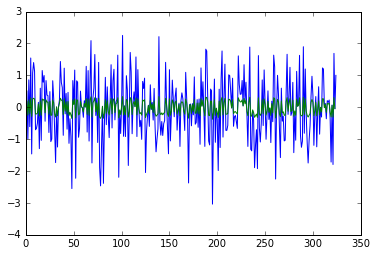

In [1019]:
c=np.random.randn(m+1)

c[m]=1
print(ynorm(c[0:m],p))
proj=ProjectionBoule(np.ones(m+1),200,c[0:m],1.)[0:m]
print(ynorm(proj,p))
plt.plot(c)
plt.plot(proj)


On peut remarquer que notre test est concluant ici. Cependant, nous avons modifié l'initialisation proposée originalement dans le papier pour que la fonction ProjectionBoule reste stable. Nous avons décidé de prendre $u^0=y$ à la place de $u^0=y/||y||_p$. En effet, lorsque la norme $p$ de $y$ était faible, $u^0$ possédait des composantes très élevées et la fonction ne convergeait pas toujours vers le résultat attendu.
Nous avons donc changé "ProjectionBoule(e/ynorm(e,p),n,e[0:m],beta)" par "ProjectionBoule(e,n,e[0:m],beta)" dans "ProjectionTube".

# 2 Projection sur le Tube $T^p(\epsilon)$

Une fois avoir projeté $y$ dans la boule unité pour la norme $p$, nous utilisons cette projection pour de calculer la projection orthogonale sur le tube $T^p(\epsilon)$.

In [928]:
def ProjectionTube(t,n,beta,phi,epsilon,u,pe,xx,ret="vec"):
    a=[]
    for i in xrange(t):
        e=1/beta*u+np.dot(phi*1/epsilon,pe)-y/epsilon
        e=np.append(e,0)
        u=beta*(e[0:m]-np.array(ProjectionBoule(e,n,e[0:m],beta)[0:m]))
        if i>50:
            if ynorm( pe-a[i-2],2.)/ynorm(pe,2.)<10**(-5):
                if ret=="vec":
                    return pe
                if ret=="tout":
                    return a
                break
        pe=xx-np.dot(u,phi*1/epsilon)
        a.append(pe)
        
    if ret=="vec":
        return pe
    if ret=="tout":
        return a

On teste ici la fonction ProjectionTube. Il est délicat de trouver des paramètres permettant une convergence convenable de la fonction.

In [929]:
o=2*np.random.randn(N)
ll=ProjectionTube(900,20,.000006,phi,.21,np.ones(m),np.ones(N),o,"tout")

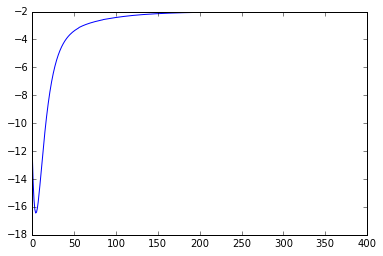

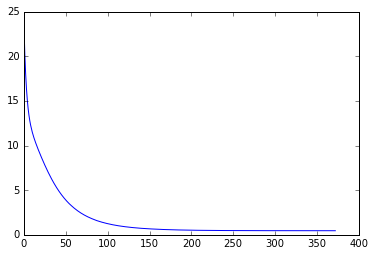

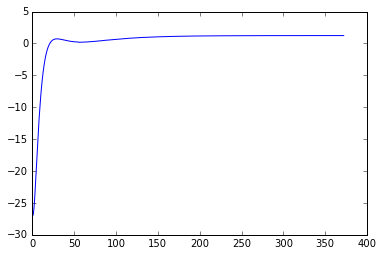

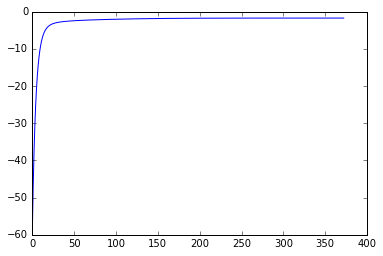

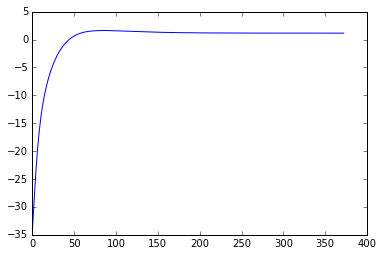

In [930]:
for i in xrange (5):
    plt.plot(np.transpose(ll)[i][1:900])
    plt.show()

In [932]:
ynorm(ll[len(ll)-1]-ll[len(ll)-2],2.)/ynorm(ll[len(ll)-1],2.)

9.9729066297769504e-06

# Douglas-Ratchford

Une fois l'opérateur qui permet de projetter sur le tube $T^p(\epsilon)$ créé, nous pouvons mettre en place l'algorithme final décrit en page 14 de l'article. Il faudra neanmoins implémenter auparavant l'opérateur de seuil mou:

In [711]:
def softthresh(v,l):
    x=[]
    for i in xrange(len(v)):
        if v[i]>0.5*l:
            x.append(v[i]-0.5*l)
        elif v[i]< -0.5*l:
            x.append(v[i]+0.5*l)
        else:
            x.append(0)
    return np.array(x)

In [885]:
softthresh([3,2.1,2,.3,4,-.2],0.5)

array([ 2.75,  1.85,  1.75,  0.05,  3.75,  0.  ])

Voici donc la fonction finale: celle qui appelle toutes les autres fonctions déclarées dans le code. Le temps d'exécution de cet algorithme est très important, c'est pourquoi on a introduit des sorties intermédiaires et que l'on affiche le temps d'exécution.

In [1025]:
def Douglas(t,n,beta,phi,epsilon,u,pe,x,a,l,j):
    t0 = time.time()
    for i in xrange(j):
        print i
        if i==2:
            print "2 étapes"
            print time.time() - t0
            plt.stem(x)
            plt.show()

        if i % 5==0:
            
            print time.time() - t0
            aa,bb,cc=plt.stem(x)
            plt.setp(bb,linewidth=1,  color= 'blue')
            plt.setp((bb[1],bb[400],bb[900]),linewidth=3,  color= 'green')
            plt.show()
            
        if i == 50:
            print "50 étapes"
            print time.time() - t0
            plt.stem(x)
            plt.show()
        if i == 100:
            print "100 étapes"
            print time.time() - t0
        x -= a * ProjectionTube(t,n,beta,phi,epsilon,u,pe,x) - a/2 * softthresh(2*ProjectionTube(t,n,beta,phi,epsilon,u,pe,2)-x,l)    
    return(x)


On remet ici toutes les constantes utilisées pour des raisons pratiques.

In [1026]:
N=1000
s=3
p=4.
t=300
n=15
beta=0.0006
m=int((math.floor(s*math.log(N/s))+1)**(p/2))
a=1
l=2
j=80

x0=np.random.normal(0, 1, N)
u=np.zeros(m)
pe=np.zeros(N)
#x=signal(N,s)
x=np.zeros(N)
x[1]=10
x[900]=15
x[400]=-4
phi=measurement_matrix(m,N)
yp=np.dot(phi,x)
y=x_quant(yp,alpha)
alpha=max(y)/40
epsilon=alpha*((m+2*(p+1)*math.sqrt(m))**(1/p))/(2*(p+1)**(1/p))
print(alpha)



1.56176760285


<Container object of 3 artists>

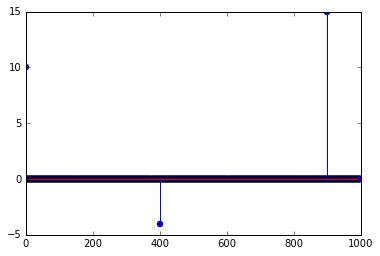

In [1027]:
plt.stem(x)

0
4.60147857666e-05


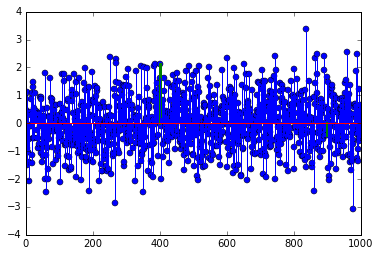

1
2
2 étapes
91.6503560543


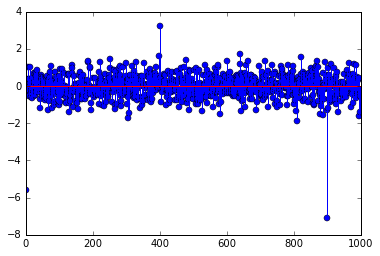

3
4
5
225.57801795


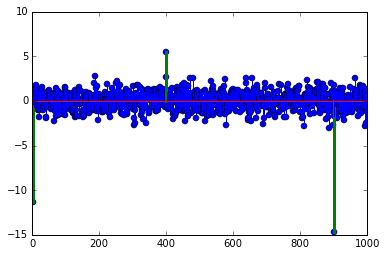

6
7
8
9
10
429.088284969


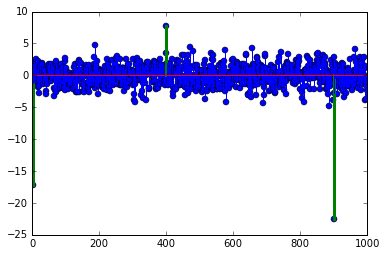

11
12
13
14
15
634.191329002


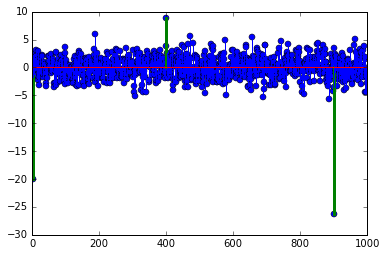

16
17
18
19
20
845.007354021


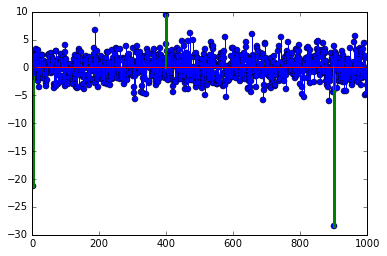

21
22
23
24
25
1058.92415214


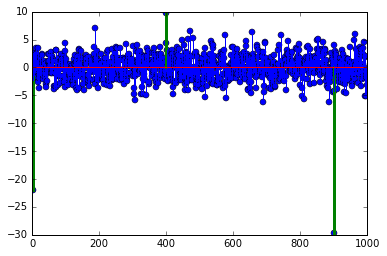

26
27
28
29
30
1281.65159512


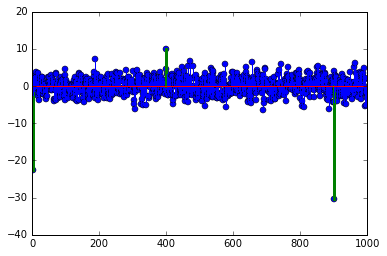

31
32
33
34
35
1548.60759807


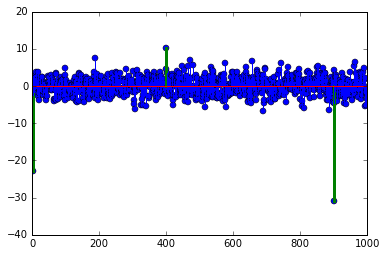

36
37
38
39
40
1776.79418302


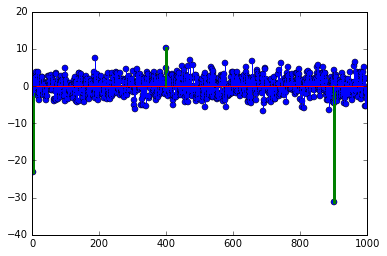

41
42
43
44
45
2009.76841807


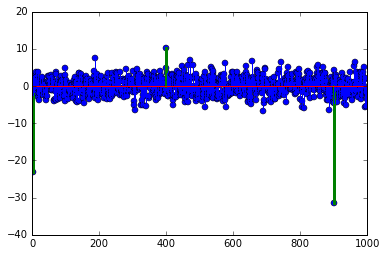

46
47
48
49
50
2243.13010216


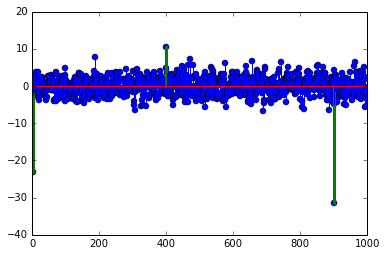

50 étapes
2245.64736414


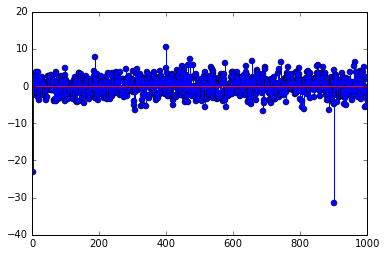

51
52
53
54
55
2479.69705915


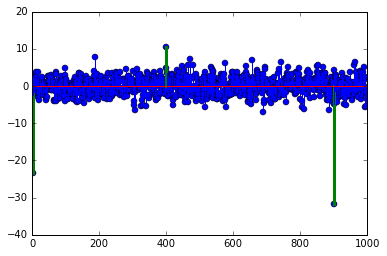

56
57
58
59
60
2712.24258804


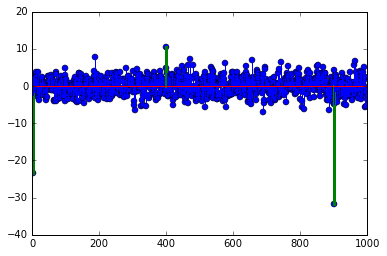

61
62
63
64
65
2963.68507409


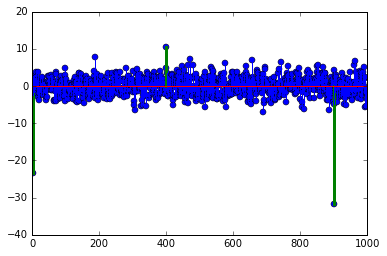

66
67
68
69
70
3195.12441897


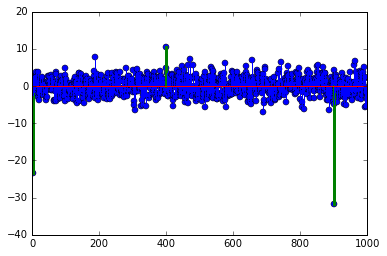

71
72
73
74
75
3432.4385581


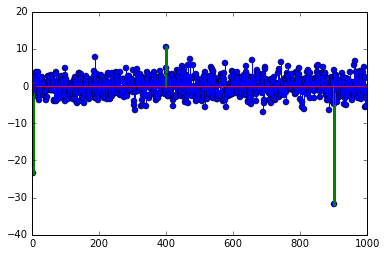

76
77
78
79


In [1028]:
fin=Douglas(t,n,beta,phi,epsilon,u,pe,x0,a,l,j)

In [1029]:
fin2=ProjectionTube(500,40,.000003,phi,.21,np.ones(m),np.ones(N),fin)

<Container object of 3 artists>

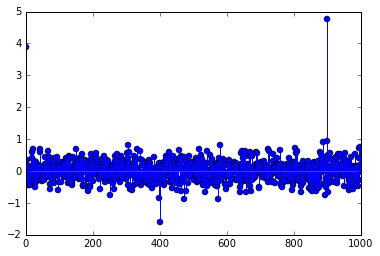

In [1030]:
plt.stem(fin2)

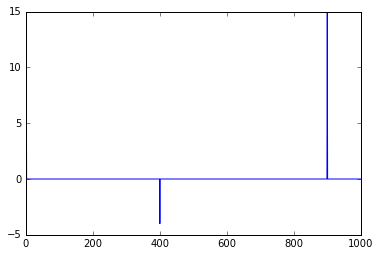

In [1032]:
plt.plot(x)